# How many weigths can we zero?

Let’s talking about the weights of neural networks.

This notebook appears by virtue of an [article](https://arxiv.org/abs/1510.00149): Song Han at all. _"Deep compression: compressing deep neural networks with pruning, trained quantization and huffman coding"_.

The main idea of the paper is that most of the weights in the network are not needed. It’s time to check this statement.


### 1. Zeroing near-zero weights. 
Now we will train the network and keep the weights from there.
After that, gradually get rid of the near-zero weights and see how the quality changes.

In [1]:
import sys

import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../../..')

from simple_model import ConvModel
from dataset.opensets import MNIST
from dataset import V, B

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

### About model:
* 2 convolution layers:
    * first layer: 
        kernel = 7x7x1, num_filters = 16 => 784 weights
    * second layer:
         kernel = 5x5x16, num_filters = 32 => 12800 weights
* 2 dense layers:
    * first layer: num_filters = 256, num_inputs = 128 => 32768 weights
    * second layer: num_filters = 10, num_inputs = 256 => 2560 weights
    
### Number of weights: 48912

Traditionally we use a dataset with MNIST data

In [3]:
mnist = MNIST()


Downloaded t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Downloaded train-labels-idx1-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Downloaded train-images-idx3-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz


Create a pipeline to train and test our model

In [4]:
train_pipeline = (
    mnist.train.p
    .init_variable('loss', init_on_each_run=list)
    .init_model('dynamic',
                ConvModel,
                'conv',
                config={'inputs': dict(images={'shape': (28, 28, 1)},
                                       labels={'classes': (10),
                                               'transform': 'ohe', 
                                               'name': 'targets'}),
                        'loss': 'ce',
                        'optimizer': 'Adam',
                        'input_block/inputs': 'images',
                        'head/units': [256, 10],
                        'output': dict(ops=['labels', 'accuracy'])})
    .train_model('conv',
                 feed_dict={'images': B('images'),
                            'labels': B('labels')})
)
test_pipeline = (
    mnist.test.p
    .import_model('conv', train_pipeline)
    .init_variable('predict', init_on_each_run=list)
    .predict_model('conv', 
                   fetches='output_accuracy',
                   feed_dict={'images': B('images'),
                              'labels': B('labels')},
                   save_to=V('predict'), 
                   mode='a')
)

After that make several iterations of the process

In [5]:
MAX_ITER = 600
for curr_iter in tqn(range(1, MAX_ITER + 1)):
    train_pipeline.next_batch(100, n_epochs=None, shuffle=True)
    test_pipeline.next_batch(100, n_epochs=None, shuffle=True)

And explore the accuracy graph

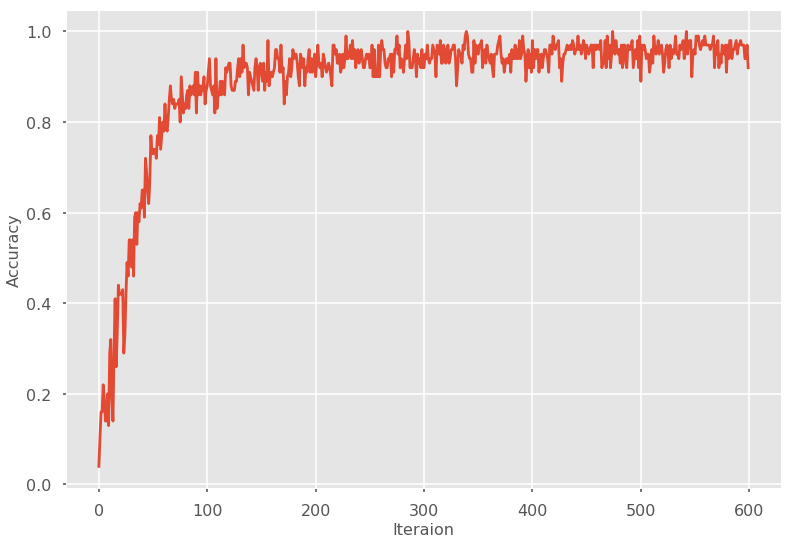

In [6]:
plt.xlabel('Iteraion', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
acc = test_pipeline.get_variable('predict')
plt.plot(acc)

Function __get_model_by_name__ returns the output of the model. In our case, we fetched tensorflow session that  allows us to get model's weights.

In [7]:
sess = train_pipeline.get_model_by_name('conv').session
graph = sess.graph

In [8]:
def apply(weights, biases):
    """ Loading weights and biases in the model
    
    Parameters
    ----------
    weights : np.array
        weights from model
    biases : np.array
        biases from model
    """
    assign = []
    for num_layer in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[num_layer], weights[num_layer//2]))
    for num_layer in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[num_layer], biases[num_layer//2]))
    sess.run(assign)

Next, let's zero weights by slowly moving the threshold from 1e-2 to 9e-2 and see how this affects the quality

In [9]:
weights, biases = [], []
variables = graph.get_collection('trainable_variables')
weights.append(sess.run(variables[::2]))
biases.append(sess.run(variables[1::2]))

weights = np.array(weights[0])
biases = np.array(biases[0])
weights_global = copy.deepcopy(weights)
biases_global = copy.deepcopy(biases)
percentage = []
accuracy = []
for const in tqn(np.linspace(1e-2, 9e-2)):
    zeros_on_layer = []
    for i in range(len(weights)):
        weight_ind = np.where(np.abs(weights[i]) < const)
        zeros_on_layer.append(len(weight_ind[0]) / np.array(weights[i].shape).prod())
        weights[i][weight_ind] = 0
        biases[i][np.where(np.abs(biases[i]) < const)] = 0
    percentage.append(zeros_on_layer)
    
    apply(weights, biases)
    test_pipeline.next_batch(100, shuffle=True)
    accuracy.append(acc[-1])

You can see two plots below. First plot reflects how number of zero parameters depends on threshold, while second one shows model's quality-threshold relation

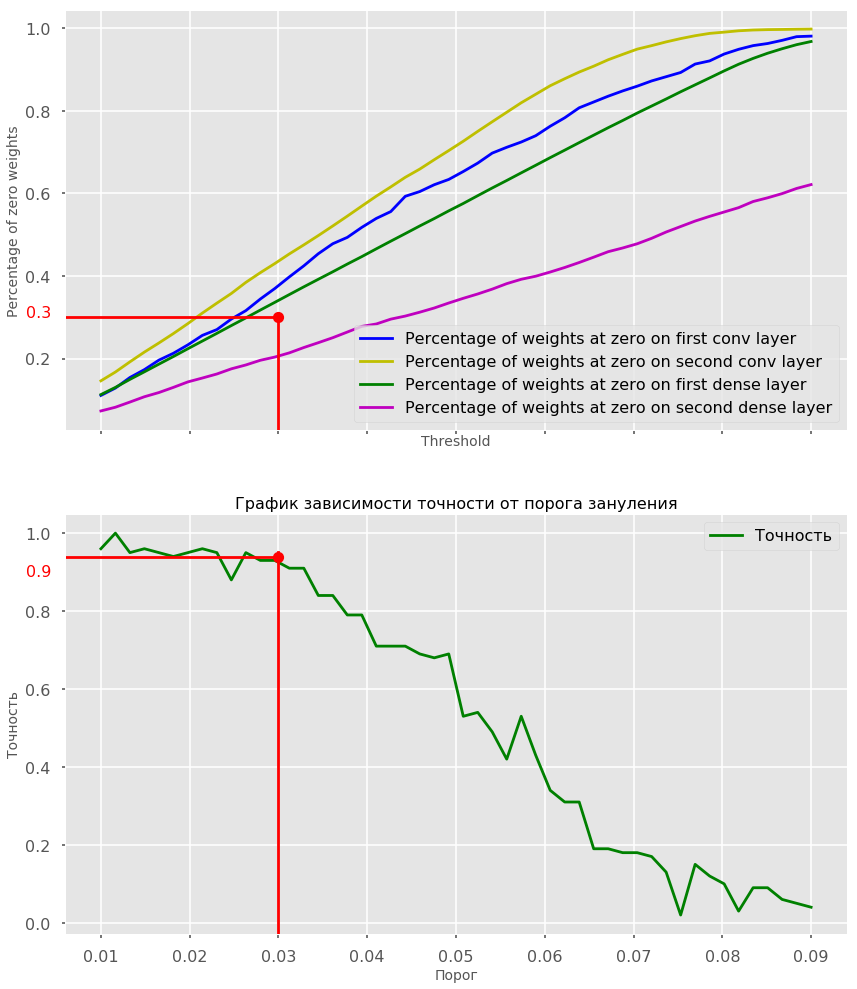

In [10]:
a = np.linspace(1e-2,9e-2)
plt.figure(figsize=(12, 8))
_, ax = plt.subplots(2, 1, sharex=True, figsize=(14, 17))
ax = ax.reshape(-1)
ax[0].set_xlabel('Threshold', fontsize=14)
ax[0].set_ylabel('Percentage of zero weights', fontsize=14)
ax[0].plot(a, np.array(percentage)[:,0], label='Percentage of weights at zero on first conv layer', c='b')
ax[0].plot(a, np.array(percentage)[:,1], label='Percentage of weights at zero on second conv layer', c='y')
ax[0].plot(a, np.array(percentage)[:,2], label='Percentage of weights at zero on first dense layer', c='g')
ax[0].plot(a, np.array(percentage)[:,3], label='Percentage of weights at zero on second dense layer', c='m')
ax[0].axvline(x=0.03, ymax=0.27, color='r')
ax[0].axhline(y=0.3, xmax=0.27, color='r')
ax[0].plot(0.03, 0.3, 'ro')
ax[0].text(0.0016, 0.3, '0.3', fontsize=16, color='r')
ax[0].legend()

plt.title('График зависимости точности от порога зануления', fontsize=16)
plt.ylabel('Точность', fontsize=14)
plt.xlabel('Порог', fontsize=14)
plt.plot(a, accuracy, label='Точность', c='g')
plt.axvline(x=0.03, ymax=0.91, color='r')
plt.axhline(y=0.94, xmax=0.27, color='r')
plt.plot(0.03, 0.94, 'ro')
plt.text(0.0016, 0.89, '0.9', fontsize=16, color='r')
plt.legend()
plt.show()

According to the graphs, you can zero about 30 percent of the scales without losing quality.

### 2. Replace weights on each layer and convert them into cluster. 
Next step is to split weights of each layer into multiple clusters using k-means algorithm and replace them by clusters centers.

If the quality doesn't change, this method can allow storing weights more optimally and, therefore, the network will weigh less. 

Now saving the parameters from the already trained network. Then replacing all weights by the values of the cluster which are the closest to the given weight. Don't forget to save the original parameters to prevent several times retraining of the network.

In [11]:
weights = copy.deepcopy(weights_global)
biases = copy.deepcopy(biases_global)

In [12]:
def clear():
    """ Function to load initial values """
    weights = copy.deepcopy(weights_global)
    biases = copy.deepcopy(biases_global)
    apply(weights, biases)

We tend to reduce the number of clusters from a notably large number, in which the quality will not change exactly, to a very small one, until the quality will drop noticeably. For each layer, the initial number of clusters is different, because there is a different number of weights in each layer. The more weights - the more corresponding clusters. You can see it in __clusters__ variable.

In [13]:
accuracy = []
clusters = np.hstack((np.linspace(30, 4, 15, dtype=np.int32), \
                      np.linspace(100, 4, 15, dtype=np.int32), \
                      np.linspace(500, 4, 15, dtype=np.int32), \
                      np.linspace(50, 4, 15, dtype=np.int32))).reshape(4,-1).T

uniq = (sum([len(np.unique(i)) for i in weights]) + sum([len(np.unique(i)) for i in biases]))
num_clusters = []
for cluster in tqn(zip(clusters, np.array([2, 2, 2, 2]*15).reshape(15, 4))):
    weights_clust, bias_clust = cluster
    num_clusters.append(np.sum(cluster))
    for i in range(4):
        kmeans = KMeans(weights_clust[i]).fit(weights[i].reshape(-1, 1).astype(np.float64))
        shape = weights[i].shape 
        weights[i] = kmeans.cluster_centers_[kmeans.predict(weights[i].reshape(-1, 1))].reshape(shape)
        kmeans = KMeans(bias_clust[i]).fit(biases[i].reshape(-1, 1))
        shape = biases[i].shape
        biases[i] = kmeans.cluster_centers_[kmeans.predict(biases[i].reshape(-1, 1))].reshape(shape)

    apply(weights, biases)
    test_pipeline.next_batch(100)
    accuracy.append(acc[-1])
    clear()

Now we can tune optimal number of clusters using quality graph

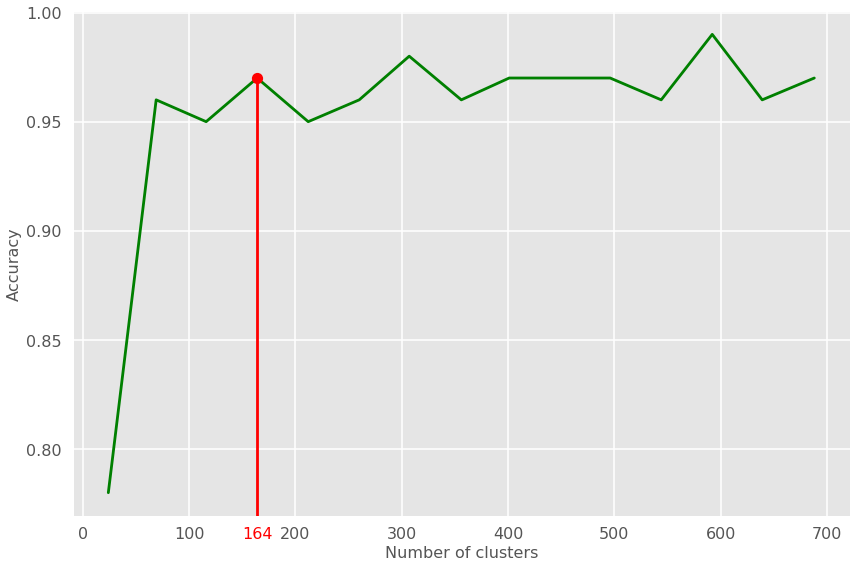

In [14]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(num_clusters, accuracy, color='g')
optimal_index = np.array([i for i in range(len(accuracy)-1) if accuracy[i] - accuracy[i+1] > 0.05][0])
plt.tight_layout()
plt.axvline(x=164, ymax=0.867, color='r')
plt.plot(163.5, 0.97, 'ro')
plt.text(150, 0.759, '164', fontsize=16, color='r')

On the graph showed that the 11th iteration is the last iteration before the sharp drop in quality. Previously, the network had 48912 parameters now there are 164. This is __300__ times less!

### Conclusion:
* 30% of the weights in the network can be removed.
* We can reduce the number of different values by 313 times
And all this works without loss of quality.

### And what's next?
You can:
* create your own network with more layers and try to cut parameters by yourself
* find the most optimal method for discovering clusters
* quantize the weights
* read and apply another experiments:
    * next [experiment](./../stochastic_depth/stochastic_depth.ipynb)
    * return to the [table of contents](./../experiments_description.ipynb).

If you still have not completed our tutorial, you can fix it right [now](./../../tutorial/00_description.ipynb)!